In [1]:
from model_2 import *
from data_2 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [6]:
N_training = 10
N_validate = 5
batch_size = 4

train_ids = np.arange(N_training)
print(train_ids)
train_generator = DataGenerator(train_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

validation_ids = np.arange(N_training, N_training+N_validate)
print(validation_ids)
validation_generator = DataGenerator(validation_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

[0 1 2 3 4 5 6 7 8 9]
Initialized with 250 total IDs
[10 11 12 13 14]
Initialized with 125 total IDs


In [4]:
with tf.device('/GPU:1'):
    model = unet(init_layers=128)
    print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 128 2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 128 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
with tf.device('/GPU:1'):
    hist = model.fit_generator(train_generator, validation_data=validation_generator, epochs=4)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/4


ResourceExhaustedError:  OOM when allocating tensor with shape[64,512,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node model/conv2d_4/Conv2D (defined at <ipython-input-5-8b7ec7c38da1>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2841]

Function call stack:
train_function


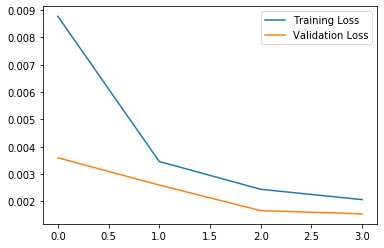

In [14]:
plt.figure()
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()

In [8]:
# Load test data
cardiac_test = np.load('../tagsim/test_data_v1.npz')

truth_data = cardiac_test['truth']

test_data = cardiac_test['test']

X = np.zeros(test_data.shape + (2,))
X[:,:,:,0] = np.real(test_data)
X[:,:,:,1] = np.imag(test_data)

with tf.device('/GPU:1'):
    res = model.predict(X)

In [9]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_X))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_res[11]))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_truth[11]))))))

NameError: name 'im_X' is not defined

<Figure size 432x288 with 0 Axes>

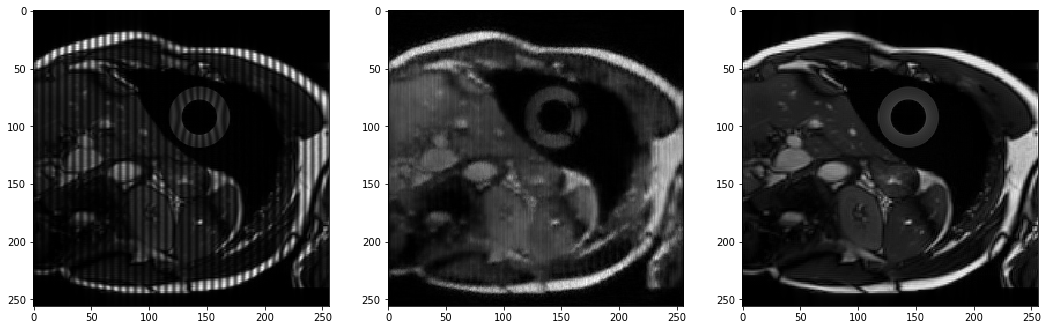

In [10]:
#Visualize magnitude of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.abs(im_X)), cmap='gray')
axs[0,1].imshow((np.abs(im_res)), cmap='gray')
axs[0,2].imshow((np.abs(im_truth)), cmap='gray')

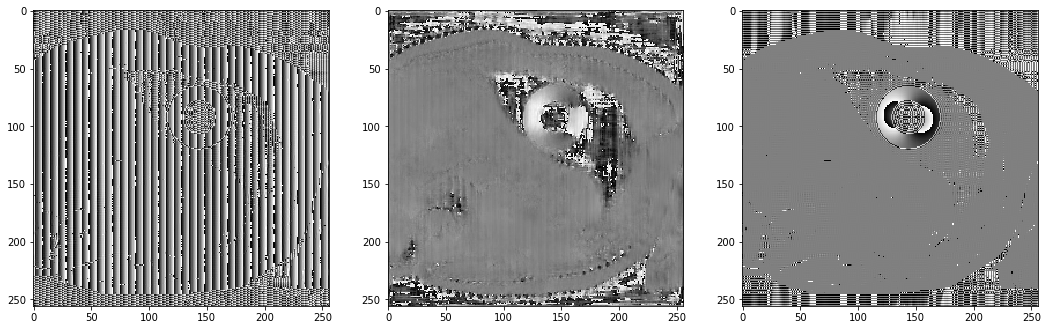

In [11]:
#Visualize phase of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.angle(im_X)), cmap='gray')
axs[0,1].imshow((np.angle(im_res)), cmap='gray')
axs[0,2].imshow((np.angle(im_truth)), cmap='gray')

Time resolved mean error: [0.047458388, 0.074926466, 0.094993524, 0.08042515, 0.08369746, 0.09329251, 0.10040482, 0.076383546, 0.03639085, -0.025839841, -0.12675759, -0.21195796, -0.31632853, -0.39530534, -0.43570936, -0.46094897, -0.4340133, -0.33623108, -0.21320458, 0.06366485, 0.15472507, 0.15781474, 0.12844415, 0.11083846, 0.15998475]
Time resolved stdev error: [0.1170883, 0.14986347, 0.20533969, 0.27774334, 0.35974416, 0.45070815, 0.5117053, 0.5822787, 0.661749, 0.7793129, 0.9522947, 1.2066758, 1.402172, 1.528441, 1.6159406, 1.6805456, 1.724404, 1.7390928, 1.697393, 1.5847346, 1.2474208, 1.0318627, 0.79297566, 0.5628553, 0.42287472]
Total Error: 0.78407294 mm  +/- 0.7975367 mm


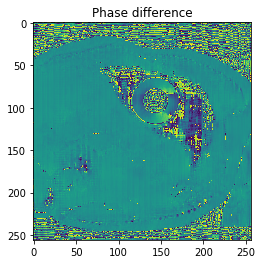

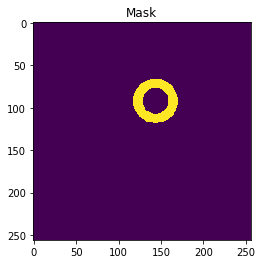

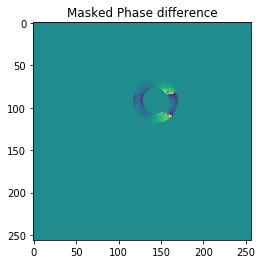

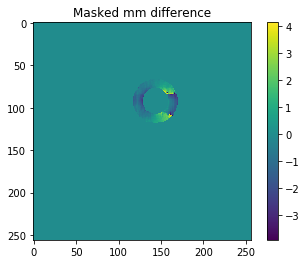

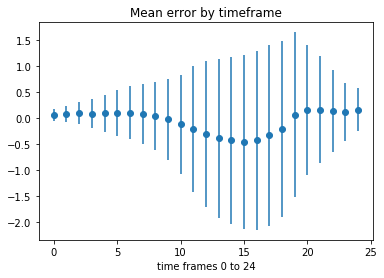

In [18]:
# Compute error:

# Phase difference of results and truth
im_res = res[:,:,:,0] + 1j * res[:,:,:,1]
im_truth = truth_data
ph_diff = np.angle(im_res * np.exp(-1j * np.angle(im_truth)))


# Plot phase difference
tt_show = 11  # timeframe to look at
plt.figure()
plt.imshow(ph_diff[tt_show])
plt.title('Phase difference')

# We dont actually care about anything but the hard, I saved a mask in the test dataset
mask = cardiac_test['mask']
plt.figure()
plt.imshow(mask[tt_show])
plt.title('Mask')

# Multiply results by the mask
ph_diff_mask = ph_diff * mask
plt.figure()
plt.imshow(ph_diff_mask[tt_show])
plt.title('Masked Phase difference')

# Convert to mm error
ke = 0.12 # This was set in simulation
mm_diff_mask = ph_diff_mask / (2*np.pi) / ke
plt.figure()
plt.imshow(mm_diff_mask[tt_show])
plt.colorbar()
plt.title('Masked mm difference')

# Calculate mean and standard deviation error, time frame specific
# We mask differently because we don't want to incorporate all the zeros from masking
err_mean = []
err_std = []
for tt in range(im_res.shape[0]):
    t_diff = mm_diff_mask[tt, mask[tt]>0]
    err_mean.append(t_diff.mean())
    err_std.append(t_diff.std())

print('Time resolved mean error:', err_mean)
print('Time resolved stdev error:', err_std)
x_ax = np.arange(25)
plt.figure()
plt.errorbar(x_ax, err_mean, yerr = err_std, fmt='o')
plt.title('Mean error by timeframe')
plt.xlabel("time frames 0 to 24")

# And the total error as a single metric
total_err = mm_diff_mask[mask>0]
print('Total Error:', np.abs(total_err).mean(), 'mm  +/-', np.abs(total_err).std(), 'mm')

## Tuning ideas
* Use all timeframes together
  * As channels (3D convolutions will be too expensive)
* Operate in k-space
* Which loss function is best
* Operate in image space, but loss function in k-space
* Play with activation functions, where to use batch normalization, learning rate adjustments, batch size
* Check initial image normalization (zero mean, stdev = 1)

## Implement validation, test data
* Validate on different simulations
* Test on the cardiac simulation
* Eventually we will test on our acquired DENSE data (I need to prep it)

In [ ]:
list(cardiac_test.keys())

In [ ]:
X.shape

In [ ]:
X.shape